<small><i>This notebook was put together by [Anderson Banihirwe](https://andersy005.github.io/) as part of [2017 CISL/SIParCS Research Project](https://ncar.github.io/PySpark4Climate/): **PySpark for Big Atmospheric & Oceanic Data Analysis**</i></small>

# Trimmed Mean

- Discards a percentage of the outlying values before calculating the arithmetic average.
- A measure that incorporates characteristics of the mean and the median.
- Less affected by outliers than the untrimmed average.
- A $x\%$  trimmed mean will eliminate the largest $x\%$ and the smallest $x\%$ of the sample before calculated the mean.
- Typical range for $x\%$ is $5\%$ to $25\%$.

Source: Wilks, Daniel S. Statistical Methods in the Atmospheric Sciences. p 26.

# Example:

- Calculate the $20\%$ trimmed mean of spatially averaged temperature data.
- The dataset can be found on [NCAR's Glade](https://www2.cisl.ucar.edu/resources/storage-and-file-systems/glade-file-spaces): 

  - ```/glade/p/CMIP/CMIP5/output1/NOAA-GFDL/GFDL-ESM2M/rcp85/mon/atmos/Amon/r1i1p1/v20111228/ta/ta_Amon_GFDL-ESM2M_rcp85_r1i1p1_200601-201012.nc```

# Step 1: Load Dataset in a Spark dataframe

In [1]:
from pyspark4climate import read
from pyspark4climate.functions import shift_lon_udf
from pyspark.sql import SparkSession
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (12, 15)
%matplotlib inline
import matplotlib.pyplot as plt
jet=plt.get_cmap('coolwarm')  # Used for multiple scatter plots

In [2]:
spark = SparkSession.builder.appName("trimmed-mean").getOrCreate()
sc = spark.sparkContext

In [3]:
!ncdump -h ../data/ta_Amon_GFDL-ESM2M_rcp85_r1i1p1_200601-201012.nc

netcdf ta_Amon_GFDL-ESM2M_rcp85_r1i1p1_200601-201012 {
dimensions:
	plev = 17 ;
	time = UNLIMITED ; // (60 currently)
	lat = 90 ;
	lon = 144 ;
	bnds = 2 ;
variables:
	double plev(plev) ;
		plev:units = "Pa" ;
		plev:long_name = "pressure" ;
		plev:axis = "Z" ;
		plev:positive = "down" ;
		plev:standard_name = "air_pressure" ;
	double average_DT(time) ;
		average_DT:long_name = "Length of average period" ;
		average_DT:units = "days" ;
	double average_T1(time) ;
		average_T1:long_name = "Start time for average period" ;
		average_T1:units = "days since 2006-01-01 00:00:00" ;
	double average_T2(time) ;
		average_T2:long_name = "End time for average period" ;
		average_T2:units = "days since 2006-01-01 00:00:00" ;
	double lat(lat) ;
		lat:long_name = "latitude" ;
		lat:units = "degrees_north" ;
		lat:standard_name = "latitude" ;
		lat:axis = "Y" ;
		lat:bounds = "lat_bnds" ;
	double lon(lon) ;
		lon:long_name = "longitude" ;
		lon:units = "degrees_east" ;
		lon:standard_name = "longitude"

In [4]:
filename='../data/ta_Amon_GFDL-ESM2M_rcp85_r1i1p1_200601-201012.nc'
var = 'ta'

In [5]:
data = read.DataFrame(sc, (filename, var), mode='single')

Pyspark4climate DataFrame class returns an object.
In order to access spark's dataframe we need to do the following:

In [6]:
type(data)

pyspark4climate.read.DataFrame

In [7]:
data_df = data.df
type(data_df)

pyspark.sql.dataframe.DataFrame

In [8]:
data_df.show()

+-------------------+--------+------------------+------------------+----+
|               time|    plev|               lat|               lon|  ta|
+-------------------+--------+------------------+------------------+----+
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            256.25|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            258.75|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            261.25|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            263.75|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            266.25|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            268.75|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            271.25|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|273.74999999999994|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            276.25|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            278.75|null|
|2006-01-16 12:00:00|100000.0|-71.7977

In [9]:
# Print the schema of data_df dataframe
data_df.printSchema()

root
 |-- time: string (nullable = true)
 |-- plev: double (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- ta: double (nullable = true)



# Step 2: Shift longitudes on grid so that they are in range [-180 -> 180]

To achieve this we will use ```pyspark4climate``` builtin function ```shift_grid_udf()```

In [10]:
# Shift grid and Drop the lon column
data_df = data_df.withColumn("shifted_lon", shift_lon_udf(data_df["lon"])).cache()
data_df = data_df.selectExpr("time", "plev", "lat", "shifted_lon as lon", "ta")

In [11]:
data_df.show()

+-------------------+--------+------------------+-------------------+----+
|               time|    plev|               lat|                lon|  ta|
+-------------------+--------+------------------+-------------------+----+
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            -103.75|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            -101.25|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|             -98.75|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|             -96.25|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|             -93.75|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|             -91.25|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|             -88.75|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527| -86.25000000000006|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|             -83.75|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|             -81.25|null|
|2006-01-16 12:00:00|1000

# Step 2: Select Temporal and Spatial Domains

Select North-America: Region with only values 60W to 130W, 20N to 70N

In [12]:
import pyspark.sql.functions as F

In [13]:
df = data_df.filter((data_df["lon"] <= -60) & (data_df["lon"] >=-130) &\
                 (data_df["lat"] >=20) & (data_df["lat"] <=70))\
                 .orderBy(F.col('time'), F.col('lat'), F.col('lon'))
df.show()

+-------------------+--------+------------------+-------------------+------------------+
|               time|    plev|               lat|                lon|                ta|
+-------------------+--------+------------------+-------------------+------------------+
|2006-01-16 12:00:00| 85000.0|21.235955056179776|-128.74999999999997|  284.496337890625|
|2006-01-16 12:00:00| 50000.0|21.235955056179776|-128.74999999999997| 261.9516906738281|
|2006-01-16 12:00:00| 70000.0|21.235955056179776|-128.74999999999997|278.41375732421875|
|2006-01-16 12:00:00|100000.0|21.235955056179776|-128.74999999999997|290.64520263671875|
|2006-01-16 12:00:00| 25000.0|21.235955056179776|-128.74999999999997|226.87403869628906|
|2006-01-16 12:00:00| 40000.0|21.235955056179776|-128.74999999999997|250.10055541992188|
|2006-01-16 12:00:00| 60000.0|21.235955056179776|-128.74999999999997|  271.363037109375|
|2006-01-16 12:00:00| 15000.0|21.235955056179776|-128.74999999999997| 208.1819610595703|
|2006-01-16 12:00:00|

# Step 3: Calculate Spatial Average
This operation computes a spatial mean. For each month, the temperature data at each spatial grid point is averaged together to generate one value.

In [14]:
spatial_avg = df.groupby('time')\
                .agg(F.avg('ta').alias('mean_ta'))\
                .orderBy(F.col('time')).cache()
spatial_avg.show()

+-------------------+------------------+
|               time|           mean_ta|
+-------------------+------------------+
|2006-01-16 12:00:00|231.59926081445633|
|2006-02-15 00:00:00|232.37893242814513|
|2006-03-16 12:00:00| 234.1541619403338|
|2006-04-16 00:00:00|235.78591857085357|
|2006-05-16 12:00:00|238.01055345426494|
|2006-06-16 00:00:00|240.42150196670758|
|2006-07-16 12:00:00| 241.9528985937708|
|2006-08-16 12:00:00| 241.2648552284146|
|2006-09-16 00:00:00| 239.6473727575904|
|2006-10-16 12:00:00|237.19174075318733|
|2006-11-16 00:00:00|234.90129093010106|
|2006-12-16 12:00:00|232.37434658849983|
|2007-01-16 12:00:00| 233.7475353484458|
|2007-02-15 00:00:00|234.06008903985523|
|2007-03-16 12:00:00|234.13952266820945|
|2007-04-16 00:00:00|236.35817862969358|
|2007-05-16 12:00:00|238.67507688947597|
|2007-06-16 00:00:00| 240.9092952795669|
|2007-07-16 12:00:00|242.37356627412072|
|2007-08-16 12:00:00|241.68422413936645|
+-------------------+------------------+
only showing top

In [17]:
spatial_avg.count()

60

# Step 4: Calculate Trimmed Mean

- Use Spark's ```approxQuantile(col, probabilities, relativeError)``` to calculate the approximate quantiles of a numerical column of a DataFrame. This function gives us the lowest $20\%$ of the values and the highest $20\%$ of the values from the dataset.

In [15]:
lowest_highest_20th_values = spatial_avg.approxQuantile("mean_ta", [0.2, 0.8], 0.001)
lowest_highest_20th_values

[233.01154807122214, 240.67232534998033]

- Discard the lowest $20\%$ of the values and the highest $20\%$ of the values from the dataset.

In [16]:
trimmed_mean = spatial_avg.where((spatial_avg["mean_ta"] > lowest_highest_20th_values[0])\
                                 & (spatial_avg["mean_ta"] < lowest_highest_20th_values[1])).cache()
trimmed_mean.show()

+-------------------+------------------+
|               time|           mean_ta|
+-------------------+------------------+
|2006-03-16 12:00:00| 234.1541619403338|
|2006-04-16 00:00:00|235.78591857085357|
|2006-05-16 12:00:00|238.01055345426494|
|2006-06-16 00:00:00|240.42150196670758|
|2006-09-16 00:00:00| 239.6473727575904|
|2006-10-16 12:00:00|237.19174075318733|
|2006-11-16 00:00:00|234.90129093010106|
|2007-01-16 12:00:00| 233.7475353484458|
|2007-02-15 00:00:00|234.06008903985523|
|2007-03-16 12:00:00|234.13952266820945|
|2007-04-16 00:00:00|236.35817862969358|
|2007-05-16 12:00:00|238.67507688947597|
|2007-09-16 00:00:00|239.50740400122888|
|2007-10-16 12:00:00|236.77807576356787|
|2007-11-16 00:00:00|234.64059489138126|
|2008-02-15 00:00:00| 233.0450955027923|
|2008-03-15 12:00:00|234.47422504273217|
|2008-04-15 00:00:00|236.04082823775568|
|2008-05-15 12:00:00|238.70110128101425|
|2008-06-15 00:00:00|240.67232534998033|
+-------------------+------------------+
only showing top

In [18]:
trimmed_mean.count()

37

## 4.1 Plot the trimmed-mean values and Spatial mean values


In [19]:
# convert the spark dataframe to pandas dataframe for visualization
df = trimmed_mean.toPandas()
df.head()

,time,mean_ta
0,2006-03-16 12:00:00,234.154162
1,2006-04-16 00:00:00,235.785919
2,2006-05-16 12:00:00,238.010553
3,2006-06-16 00:00:00,240.421502
4,2006-09-16 00:00:00,239.647373


In [20]:
df.describe()

,mean_ta
count,37.000000
mean,236.560735
std,2.379737
min,233.011548
25%,234.416524
50%,236.358179
75%,238.675077
max,240.672325


In [21]:
df = df.set_index('time')
df.head()

,mean_ta
time,
2006-03-16 12:00:00,234.154162
2006-04-16 00:00:00,235.785919
2006-05-16 12:00:00,238.010553
2006-06-16 00:00:00,240.421502
2006-09-16 00:00:00,239.647373


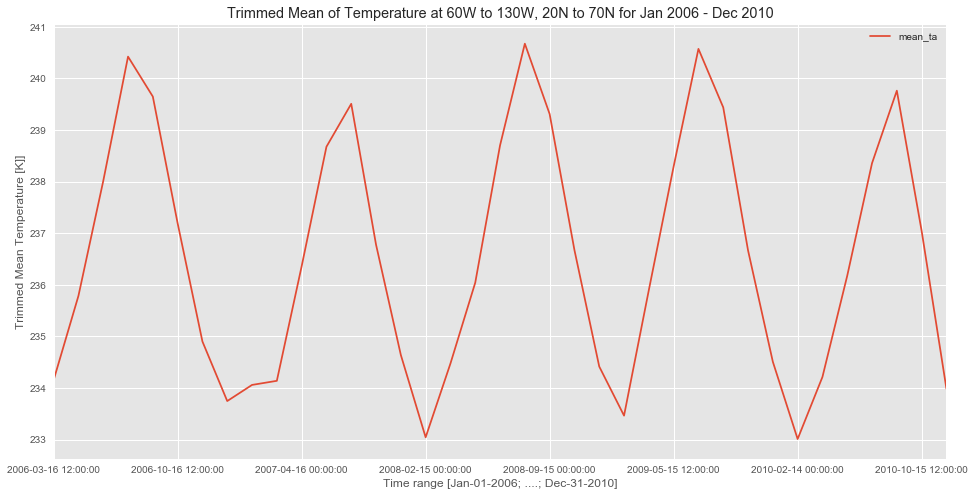

In [23]:
ax = df['mean_ta'].plot(legend=True, figsize=(16, 8))
ax.set_xlabel("Time range [Jan-01-2006; ....; Dec-31-2010]")
ax.set_ylabel("Trimmed Mean Temperature [K]]")
ax.set_title("Trimmed Mean of Temperature at 60W to 130W, 20N to 70N for Jan 2006 - Dec 2010")
plt.show()

## 4.2 Plot the Spatial mean temperature values

In [24]:
spatial_avg_df = spatial_avg.toPandas()
spatial_avg_df.describe()

,mean_ta
count,60.000000
mean,236.757677
std,3.538398
min,231.549194
25%,233.926710
50%,236.512822
75%,239.926692
max,242.373566


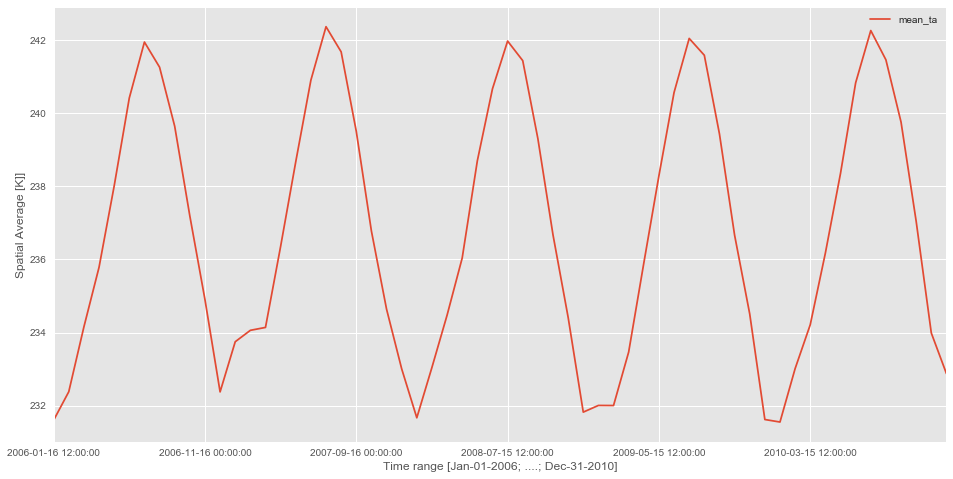

In [25]:
spatial_avg_df = spatial_avg_df.set_index('time')
ax = spatial_avg_df['mean_ta'].plot(legend=True, figsize=(16, 8))
ax.set_xlabel("Time range [Jan-01-2006; ....; Dec-31-2010]")
ax.set_ylabel("Spatial Average [K]]")
plt.show()

## 4.3 Plot of Trimmed Mean and Spatial Mean Temperatures

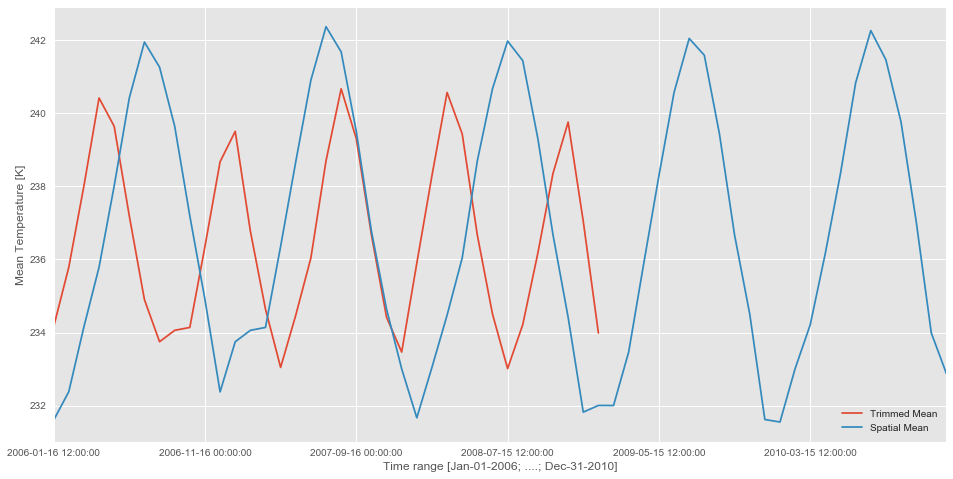

In [35]:
ax = df['mean_ta'].plot(legend=True, figsize=(16, 8), label='Trimmed Mean')
ax = spatial_avg_df['mean_ta'].plot(legend=True, figsize=(16, 8), label='Spatial Mean')
ax.set_ylabel("Mean Temperature [K]")
ax.set_xlabel("Time range [Jan-01-2006; ....; Dec-31-2010]")
plt.show()